<h1>Edge Detection, Morphological Processing and Digital Halftoning</h1>

<h3>Problem 1: Edge Detection (30%)</h3>
<p>An edge map is a binary image, where 0 implies the edge, and 255 implies the background.Please perform edge detection on the two images in Figure 1 (i.e., building.raw and building_noise.raw) and show the edge map results in your report.</p>
<p>(a) Basic edge detection algorithms.Please implement two basic edge detection algorithms: the 1st-order derivative gradient method and the 2nd-order derivative plus zero crossing. Please discuss how you choose the threshold values which are required in each of the two algorithms.</p>
<p>(b) Advanced edge detection algorithms. Please implement some pre-processing and post-processing tools to improve the results from (a). For example, you might want to enhance the contrast of Figure 1(a) and perform noise removal on Figure 1(b). State your pre-processing and post-processing steps clearly in your report and explain how they help in your obtained edge detection results.</p>


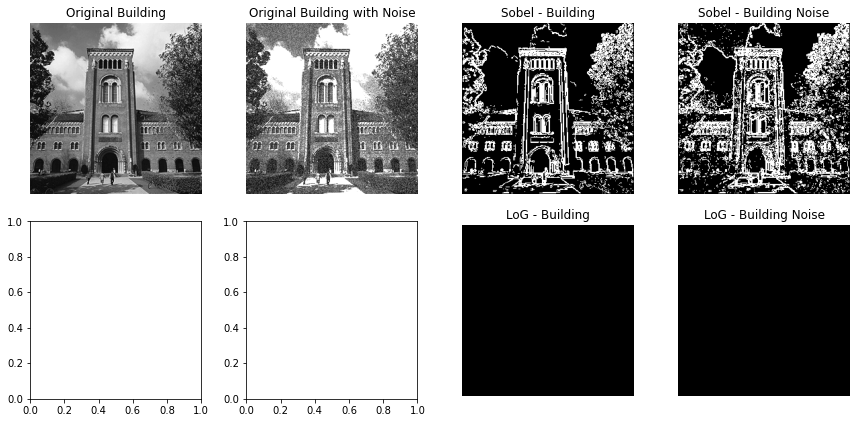

In [69]:
#Basic edge detection algorithms
import numpy as np
from matplotlib import pyplot as plt

def gaussian_kernel(size, sigma=1.0):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

def convolve2d(image, kernel):
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    result = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            result[i, j] = np.sum(kernel * padded_image[i:i+kernel_height, j:j+kernel_width])
    return result

def sobel_operator(image):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    gradient_x = np.zeros_like(image, dtype=float)
    gradient_y = np.zeros_like(image, dtype=float)

    rows, cols = image.shape
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            gradient_x[i, j] = np.sum(sobel_x * image[i - 1:i + 2, j - 1:j + 2])
            gradient_y[i, j] = np.sum(sobel_y * image[i - 1:i + 2, j - 1:j + 2])

    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    magnitude = magnitude / magnitude.max() * 255
    edge_map = (magnitude > 50).astype(np.uint8) * 255

    return edge_map

def laplacian_of_gaussian(image):
    g_kernel = gaussian_kernel(5, sigma=1.0)
    blurred_image = convolve2d(image, g_kernel)

    laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    log_image = convolve2d(blurred_image, laplacian_kernel)

    edge_map = np.zeros_like(log_image)
    threshold = np.absolute(log_image).mean() * 0.75
    for i in range(1, log_image.shape[0]-1):
        for j in range(1, log_image.shape[1]-1):
            patch = log_image[i-1:i+2, j-1:j+2]
            min_val = patch.min()
            max_val = patch.max()
            if min_val < 0 and max_val > 0 and max_val - min_val > threshold:
                edge_map[i, j] = 255

    return edge_map


# Displaying the results
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Original images
axes[0, 0].imshow(building_image, cmap='gray')
axes[0, 0].set_title('Original Building')
axes[0, 0].axis('off')
axes[0, 1].imshow(building_noise_image, cmap='gray')
axes[0, 1].set_title('Original Building with Noise')
axes[0, 1].axis('off')

# Sobel edge detection
axes[0, 2].imshow(sobel_building, cmap='gray')
axes[0, 2].set_title('Sobel - Building')
axes[0, 2].axis('off')
axes[0, 3].imshow(sobel_building_noise, cmap='gray')
axes[0, 3].set_title('Sobel - Building Noise')
axes[0, 3].axis('off')

# LoG edge detection
axes[1, 2].imshow(log_building, cmap='gray')
axes[1, 2].set_title('LoG - Building')
axes[1, 2].axis('off')
axes[1, 3].imshow(log_building_noise, cmap='gray')
axes[1, 3].set_title('LoG - Building Noise')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()


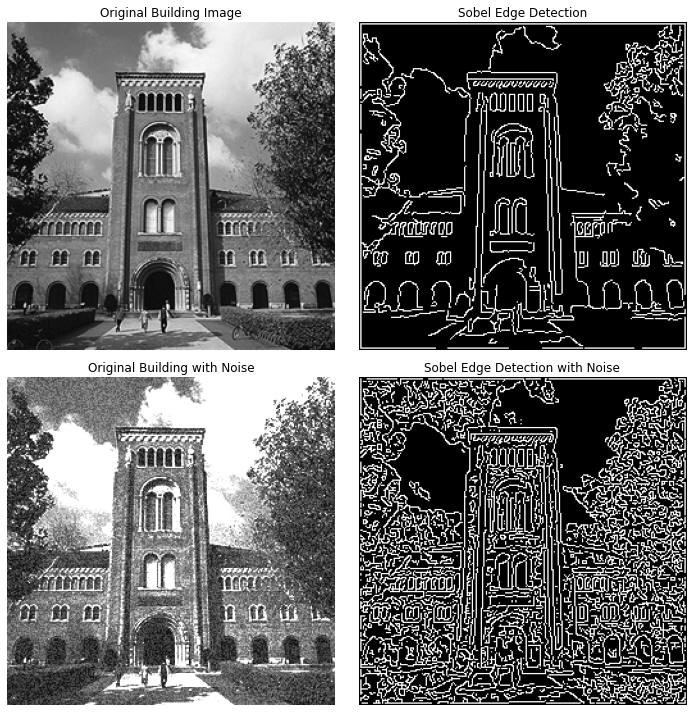

In [70]:
#Advanced edge detection уalgorithms

import numpy as np
from scipy import ndimage
from skimage import feature
import matplotlib.pyplot as plt

# Consolidating the edge detection methods into one with a parameter to switch between methods
def edge_detection(image, method='sobel', sigma=1.0):
    if method == 'sobel':
        return feature.canny(image, sigma=sigma)
    elif method == 'log':
        blurred = ndimage.gaussian_filter(image, sigma=sigma)
        laplacian = ndimage.laplace(blurred)
        zero_crossings = np.where(np.diff(np.sign(laplacian), axis=0), 1, 0)
        return zero_crossings

# We load the images only once as they are used multiple times.
# We also pass the shape as a parameter to make the function more general.
def load_and_process_image(file_path, shape=(256, 256), method='sobel', sigma=1.0):
    try:
        # Load image from file
        with open(file_path, 'rb') as rawfile:
            img = np.fromfile(rawfile, dtype=np.uint8).reshape(shape)
        # Process image
        edges = edge_detection(img, method=method, sigma=sigma)
        return img, edges
    except IOError:
        print(f"Error: File {file_path} not accessible.")
        return None, None

# Load the images and process them
building_image, edges_building = load_and_process_image('./Project2_Images/building.raw')
building_noise_image, edges_building_noise = load_and_process_image('./Project2_Images/building_noise.raw')
_, edges_building_log = load_and_process_image('./Project2_Images/building.raw', method='log', sigma=2)
_, edges_building_noise_log = load_and_process_image('./Project2_Images/building_noise.raw', method='log', sigma=2)

# Check if images were loaded successfully before proceeding to plot
if building_image is not None and building_noise_image is not None:
    # Plot the results using a more concise loop
    titles = ['Original Building Image', 'Sobel Edge Detection',
              'Original Building with Noise', 'Sobel Edge Detection with Noise']
    images = [building_image, edges_building, building_noise_image, edges_building_noise]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for ax, img, title in zip(axes.ravel(), images, titles):
        ax.imshow(img, cmap=plt.cm.gray)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


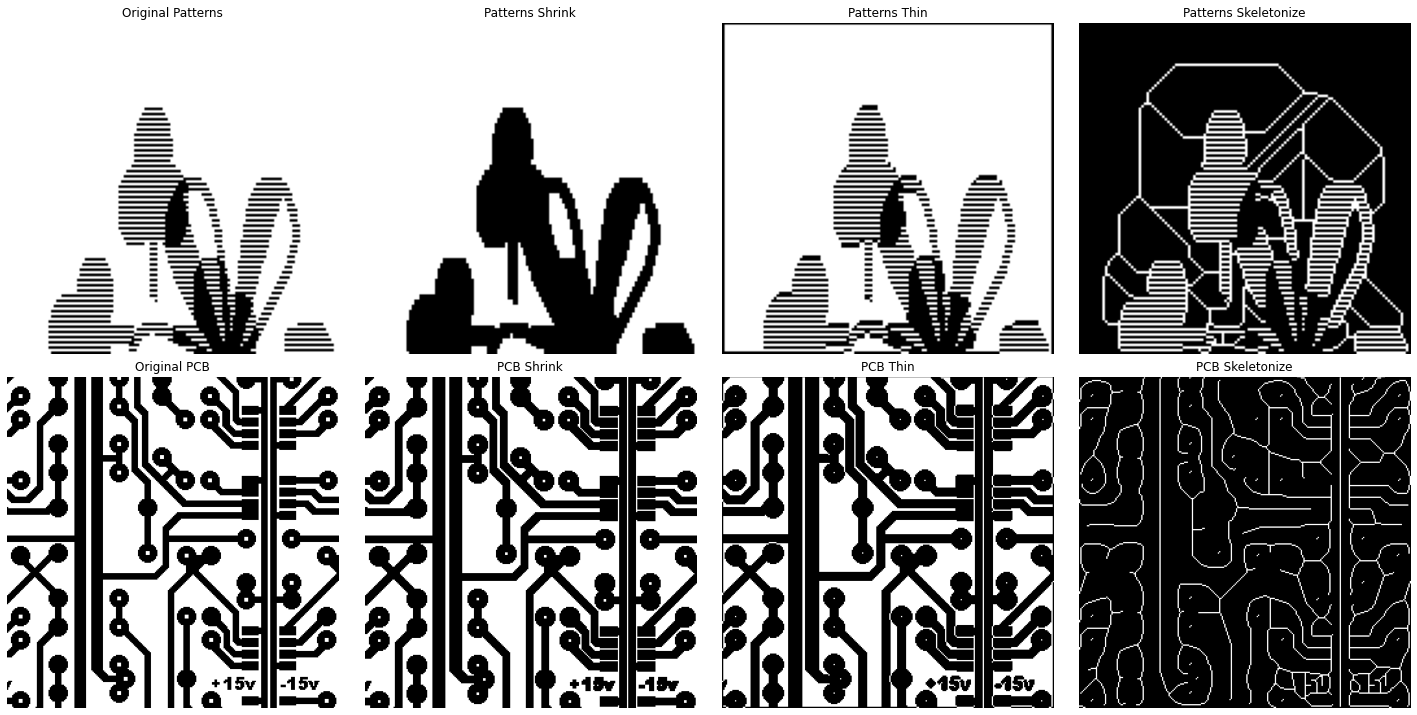

In [26]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize, thin

# Let's define a function to read raw images, since they are not standard image files.
def read_raw_image(path, width, height):
    # Assuming the images are grayscale
    with open(path, 'rb') as f:
        img = np.fromfile(f, dtype=np.uint8, count=width*height)
        img = img.reshape((height, width))
    return img

# Define a function to apply morphological operations
def morphological_operations(image, operation):
    if operation == 'shrink':
        # Use cv2.erode to apply shrinking
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
        return cv2.erode(image, kernel, iterations=1)
    elif operation == 'thin':
        # Use skimage's thin function
        return thin(image, max_num_iter=1)
    elif operation == 'skeletonize':
        # Use skimage's skeletonize function
        return skeletonize(image // 255) * 255  # skimage expects boolean image
    else:
        raise ValueError("Unsupported operation")

# Read the images
patterns_img = read_raw_image("./Project2_Images/patterns.raw", 128, 128)  # Assuming 128x128 size for example
pcb_img = read_raw_image('./Project2_Images/pcb.raw', 256, 256)  # Assuming 256x256 size for example

# Apply the morphological operations
patterns_shrink = morphological_operations(patterns_img, 'shrink')
patterns_thin = morphological_operations(patterns_img, 'thin')
patterns_skeletonize = morphological_operations(patterns_img, 'skeletonize')

pcb_shrink = morphological_operations(pcb_img, 'shrink')
pcb_thin = morphological_operations(pcb_img, 'thin')
pcb_skeletonize = morphological_operations(pcb_img, 'skeletonize')

# Display the results
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Original images
axs[0, 0].imshow(patterns_img, cmap='gray')
axs[0, 0].title.set_text('Original Patterns')
axs[1, 0].imshow(pcb_img, cmap='gray')
axs[1, 0].title.set_text('Original PCB')

# Shrinking results
axs[0, 1].imshow(patterns_shrink, cmap='gray')
axs[0, 1].title.set_text('Patterns Shrink')
axs[1, 1].imshow(pcb_shrink, cmap='gray')
axs[1, 1].title.set_text('PCB Shrink')

# Thinning results
axs[0, 2].imshow(patterns_thin, cmap='gray')
axs[0, 2].title.set_text('Patterns Thin')
axs[1, 2].imshow(pcb_thin, cmap='gray')
axs[1, 2].title.set_text('PCB Thin')

# Skeletonizing results
axs[0, 3].imshow(patterns_skeletonize, cmap='gray')
axs[0, 3].title.set_text('Patterns Skeletonize')
axs[1, 3].imshow(pcb_skeletonize, cmap='gray')
axs[1, 3].title.set_text('PCB Skeletonize')

# Remove the axis labels for clarity
for ax in axs.flat:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


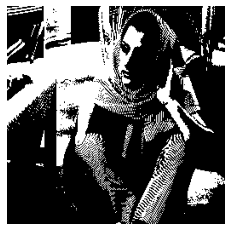

In [50]:
#(a) Fixed Threshold Dithering
import numpy as np
import matplotlib.pyplot as plt

# Complete Python code to implement Fixed Threshold Dithering on the 'barbara.raw' image

# Define the threshold T
T = 127

# Read the raw image data
image_path = "./Project2_Images/barbara.raw"
# We now know the image size is 256x256 from the previous attempt
image_size = 256

# Load the image data
with open(image_path, 'rb') as file:
    img_data = np.fromfile(file, dtype=np.uint8)
    img_data = img_data.reshape((image_size, image_size))

# Apply fixed threshold dithering
binary_img = np.where(img_data < T, 0, 255)

# Display the binary image
plt.imshow(binary_img, cmap='gray')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


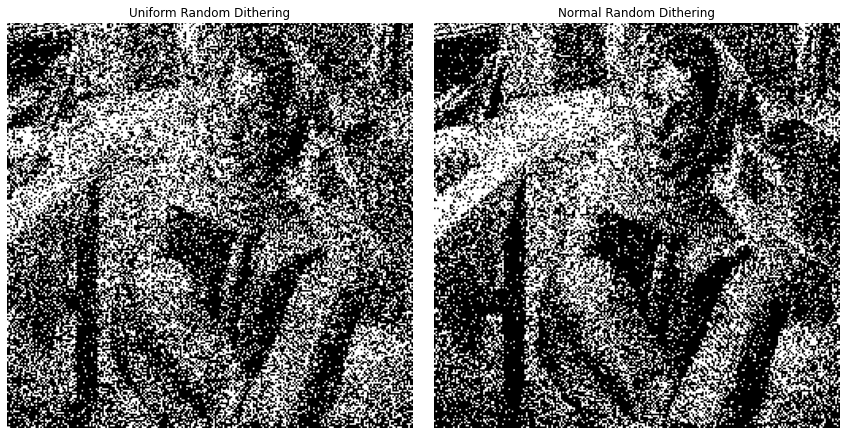

In [56]:
#(b) Random Dithering
import numpy as np
import matplotlib.pyplot as plt


# Load the image data
image_path = './Project2_Images/barbara.raw'
image_size = 256  # Image dimensions (256x256)

with open(image_path, 'rb') as file:
    img_data = np.fromfile(file, dtype=np.uint8).reshape((image_size, image_size))

# Function to perform random dithering using a uniform distribution
def random_dithering_uniform(image_data):
    random_threshold = np.random.randint(0, 256, image_data.shape)
    return np.where(image_data < random_threshold, 0, 255)

# Function to perform random dithering using a normal distribution
def random_dithering_normal(image_data):
    # Generate random numbers with a mean of 127 and std deviation such that most values fall within 0-255
    random_threshold = np.random.randn(*image_data.shape) * 64 + 127
    random_threshold = np.clip(random_threshold, 0, 255)  # Clip to ensure values are within range
    return np.where(image_data < random_threshold, 0, 255)

# Perform random dithering with both distributions
binary_img_uniform = random_dithering_uniform(img_data)
binary_img_normal = random_dithering_normal(img_data)

# Display the binary images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Uniform random dithering
ax[0].imshow(binary_img_uniform, cmap='gray')
ax[0].set_title('Uniform Random Dithering')
ax[0].axis('off')

# Normal random dithering
ax[1].imshow(binary_img_normal, cmap='gray')
ax[1].set_title('Normal Random Dithering')
ax[1].axis('off')

plt.tight_layout()
plt.show()


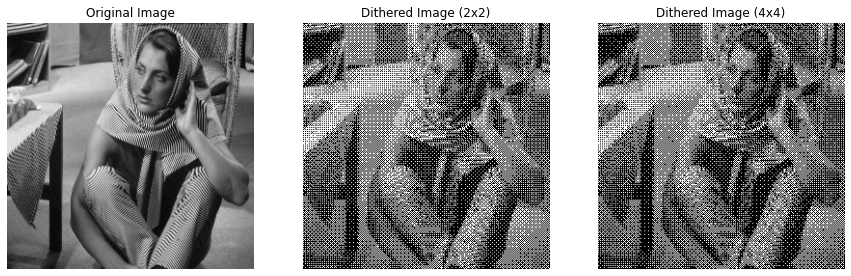

In [62]:
#(c) Dithering Matrix (Pattern)
import numpy as np
import matplotlib.pyplot as plt

# Function to load the raw image file and convert it into a numpy array
def load_raw_image(file_path, size=(256, 256)):
    with open(file_path, 'rb') as file:
        img = np.fromfile(file, dtype=np.uint8)
        img = img.reshape(size)
    return img

# Function to create the Bayer dithering matrix recursively
def bayer_matrix(order):
    if order == 1:
        return np.array([[0, 2], [3, 1]], dtype=np.float32)
    else:
        smaller_matrix = bayer_matrix(order // 2)
        four_times_smaller_matrix = 4 * smaller_matrix
        new_matrix = np.block([
            [four_times_smaller_matrix, four_times_smaller_matrix + 2],
            [four_times_smaller_matrix + 3, four_times_smaller_matrix + 1]
        ])
        return new_matrix

# Function to dither the image using a threshold matrix
def dither_image(image, threshold_matrix):
    N = threshold_matrix.shape[0]
    threshold_matrix = threshold_matrix / (N * N) * 255
    tiled_matrix = np.tile(threshold_matrix, (image.shape[0] // N, image.shape[1] // N))
    return np.where(image > tiled_matrix, 255, 0)

# Load the Barbara image
barbara_image = load_raw_image('./Project2_Images/barbara.raw')

# Create the 2x2 and 4x4 Bayer matrices
bayer_2x2 = bayer_matrix(2)
bayer_4x4 = bayer_matrix(4)

# Dither the Barbara image using the 2x2 and 4x4 Bayer matrices
dithered_barbara_2x2 = dither_image(barbara_image, bayer_2x2)
dithered_barbara_4x4 = dither_image(barbara_image, bayer_4x4)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(barbara_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(dithered_barbara_2x2, cmap='gray')
axes[1].set_title('Dithered Image (2x2)')
axes[1].axis('off')

axes[2].imshow(dithered_barbara_4x4, cmap='gray')
axes[2].set_title('Dithered Image (4x4)')
axes[2].axis('off')

plt.show()


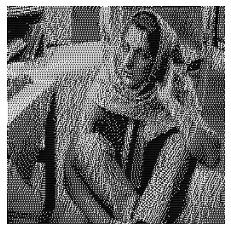

In [33]:
#(d) Implement Floyd-Steinberg's error diffusion with serpentine scanning
import numpy as np
import matplotlib.pyplot as plt

# Load the image file
file_path = './Project2_Images/barbara.raw'
with open(file_path, 'rb') as file:
    image_data = np.fromfile(file, dtype=np.uint8)
    size = int(np.sqrt(image_data.size))  # Assuming the image is square
    image = image_data.reshape((size, size))

# Floyd-Steinberg's error diffusion algorithm with serpentine scanning
def floyd_steinberg_dither(image):
    height, width = image.shape
    for y in range(height):
        if y % 2 == 0:  # Left to right on even rows
            x_range = range(width)
        else:  # Right to left on odd rows
            x_range = range(width - 1, -1, -1)

        for x in x_range:
            old_pixel = image[y, x]
            new_pixel = 255 if old_pixel > 127 else 0
            image[y, x] = new_pixel
            error = old_pixel - new_pixel

            if x + 1 < width:
                image[y, x + 1] += error * 7 / 16
            if x - 1 >= 0 and y + 1 < height:
                image[y + 1, x - 1] += error * 3 / 16
            if y + 1 < height:
                image[y + 1, x] += error * 5 / 16
            if x + 1 < width and y + 1 < height:
                image[y + 1, x + 1] += error * 1 / 16

    return image

# Apply the algorithm
dithered_image = floyd_steinberg_dither(image.copy())

# Plot the final image
plt.imshow(dithered_image, cmap='gray')
plt.axis('off')
plt.show()
